In [3]:
import numpy as np
import matplotlib.pyplot as plt
plt.style.use('seaborn-whitegrid')
from scipy import stats

In [2]:
from sklearn.datasets import fetch_lfw_people
faces = fetch_lfw_people(min_faces_per_person=60)
print(faces.target_names)
print(faces.images.shape)

 Traceback (most recent call last):
  File "/Library/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/joblib/memory.py", line 516, in _cached_call
    out = self.store_backend.load_item(
  File "/Library/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/joblib/_store_backends.py", line 170, in load_item
    item = numpy_pickle.load(f)
  File "/Library/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/joblib/numpy_pickle.py", line 577, in load
    obj = _unpickle(fobj)
  File "/Library/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/joblib/numpy_pickle.py", line 506, in _unpickle
    obj = unpickler.load()
  File "/Library/Frameworks/Python.framework/Versions/3.8/lib/python3.8/pickle.py", line 1210, in load
    dispatch[key[0]](self)
KeyError: 0



['Ariel Sharon' 'Colin Powell' 'Donald Rumsfeld' 'George W Bush'
 'Gerhard Schroeder' 'Hugo Chavez' 'Junichiro Koizumi' 'Tony Blair']
(1348, 62, 47)


Let’s plot a few of these faces to see what we’re working with:

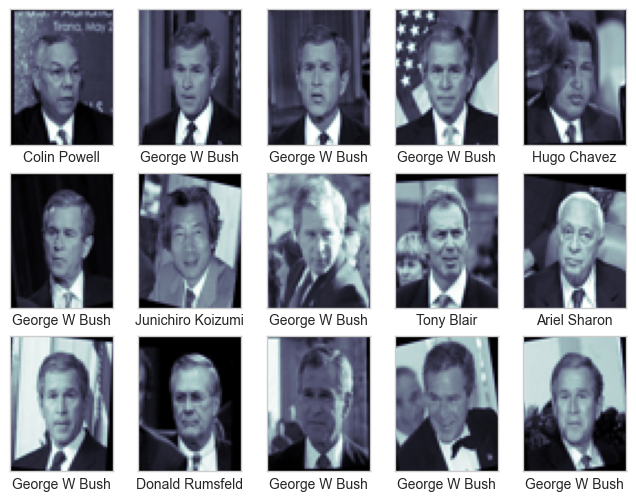

In [4]:
fig, ax = plt.subplots(3, 5, figsize=(8, 6))
for i, axi in enumerate(ax.flat):
    axi.imshow(faces.images[i], cmap='bone')
    axi.set(xticks=[], yticks=[],
            xlabel=faces.target_names[faces.target[i]])

Each image contains [62×47] or around 3,000 pixels. We could proceed by simply using each pixel value as a feature, but often it is more effective to use some sort of preprocessor to extract more meaningful features; here we will use a principal component analysis (see Chapter 45) to extract 150 fundamental components to feed into our support vector machine classifier. We can do this most straightforwardly by packaging the preprocessor and the classifier into a single pipeline:

In [5]:
from sklearn.svm import SVC
from sklearn.decomposition import PCA
from sklearn.pipeline import make_pipeline

pca = PCA(n_components=150, whiten=True,
          svd_solver='randomized', random_state=42)
svc = SVC(kernel='rbf', class_weight='balanced')
model = make_pipeline(pca, svc)

For the sake of testing our classifier output, we will split the data into a training and testing set:

In [6]:
from sklearn.model_selection import train_test_split
Xtrain, Xtest, ytrain, ytest = train_test_split(faces.data, faces.target,
                                                random_state=42)

Finally, we can use a grid search cross-validation to explore combinations of parameters. Here we will adjust C (which controls the margin hardness) and gamma (which controls the size of the radial basis function kernel), and determine the best model:

In [7]:
from sklearn.model_selection import GridSearchCV
param_grid = {'svc__C': [1, 5, 10, 50],
              'svc__gamma': [0.0001, 0.0005, 0.001, 0.005]}
grid = GridSearchCV(model, param_grid)

%time grid.fit(Xtrain, ytrain)
print(grid.best_params_)

CPU times: user 57.6 s, sys: 40 s, total: 1min 37s
Wall time: 30.7 s
{'svc__C': 50, 'svc__gamma': 0.005}


The optimal values fall toward the middle of our grid; if they fell at the edges, we would want to expand the grid to make sure we have found the true optimum.

Now with this cross-validated model, we can predict the labels for the test data, which the model has not yet seen:

In [8]:
model = grid.best_estimator_
yfit = model.predict(Xtest)

Let’s take a look at a few of the test images along with their predicted values:

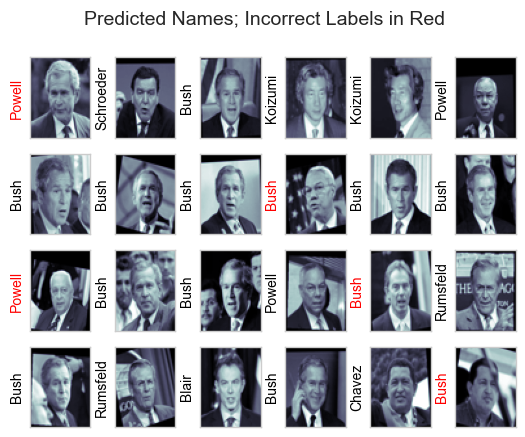

In [9]:
fig, ax = plt.subplots(4, 6)
for i, axi in enumerate(ax.flat):
    axi.imshow(Xtest[i].reshape(62, 47), cmap='bone')
    axi.set(xticks=[], yticks=[])
    axi.set_ylabel(faces.target_names[yfit[i]].split()[-1],
                   color='black' if yfit[i] == ytest[i] else 'red')
fig.suptitle('Predicted Names; Incorrect Labels in Red', size=14);

Out of this small sample, our optimal estimator mislabeled only a single face (Bush’s face in the bottom row was mislabeled as Blair). We can get a better sense of our estimator’s performance using the classification report, which lists recovery statistics label by label:

In [10]:
from sklearn.metrics import classification_report
print(classification_report(ytest, yfit,
                            target_names=faces.target_names))

                   precision    recall  f1-score   support

     Ariel Sharon       0.91      0.67      0.77        15
     Colin Powell       0.84      0.85      0.85        68
  Donald Rumsfeld       0.72      0.58      0.64        31
    George W Bush       0.76      0.92      0.83       126
Gerhard Schroeder       0.75      0.65      0.70        23
      Hugo Chavez       1.00      0.45      0.62        20
Junichiro Koizumi       0.91      0.83      0.87        12
       Tony Blair       0.80      0.76      0.78        42

         accuracy                           0.80       337
        macro avg       0.84      0.71      0.76       337
     weighted avg       0.80      0.80      0.79       337



We might also display the confusion matrix between these classes:

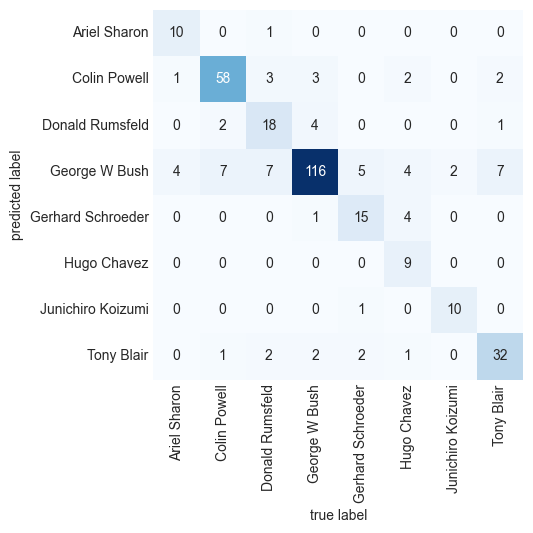

In [11]:
from sklearn.metrics import confusion_matrix
import seaborn as sns
mat = confusion_matrix(ytest, yfit)
sns.heatmap(mat.T, square=True, annot=True, fmt='d',
            cbar=False, cmap='Blues',
            xticklabels=faces.target_names,
            yticklabels=faces.target_names)
plt.xlabel('true label')
plt.ylabel('predicted label');

This helps us get a sense of which labels are likely to be confused by the estimator.